# Exercise T: Optimized code and gradients computation using Theano

So far you have learn how to perform numerical methods in Python mainly using numpy. One of the main criticism of Python is its relative slow performance compared with other languages. Despite the huge leap that using numpy respect pure Python represents most of the operation in numpy still use single core architectures.

However, if Python suffers in performance where it really shines is in flexibility. Cython (http://cython.org/) or PyCUDA (https://documen.tician.de/pycuda/) are two good examples of libraries that use the easy to learn Python syntaxis combining it with the speed or lower levels languages.

Today we will learn to use the symbolic package Theano (http://deeplearning.net/software/theano/)). Theano originally started as a research project in neuro networks by the University of Monreal but also its symbolic code facilitate the use of Cython and PyCUDA.

## Introducing Theano

Theano is a Python package that take over many of the optimization tasks in order to create a feasible and fast code. Theano relies on the creation of symbolical graphs that represent the mathematical expressions to compute. Most of the extended programming paradigms (e.g. procedural languages and object-oriented programming) are executed sequentially without any interaction with the subsequent instructions. In contrast, symbolic programming allows to have the primary data structure and logic of a function defined from the beginning to the end what, in turn, enables the manipulation of this description. 

The Python code is used to create an acyclic network graph where the parameters are represented by the nodes while the connections determine the mathematical operator that relates them. The creation of the graph is done in the class \texttt{theanograph}. Each method correspond to a piece of the graph starting from the input data all the way to the geological model or the forward gravity (see figure \ref{fig:overall}, theano area).

The symbolic graphs is later analyzed to perform the optimizers, the symbolic differentiation and the compilation to a faster language than Python (C or CUDA). This process is computational demanding and therefore it must to be avoided as much as possible.

Among the most outstanding optimizers be can find: (i) the canonicalization of the operations to simplify unnecessary computations, (ii) specialization of operation what improves consecutive element-wise operation, (iii) in-place operations to avoid duplications of memory or (iv) Open MP parallelization for CPU computations. These optimizations and more can speed up the code an order of magnitude.

## Minimal example

### Installation
First of all we will need to install Theano. In macOS and linux with a ```conda install theano``` in the console should be suficient. For Windows users they would need the extra step of installing the GCC compiler for using C code.

To use the GPU would be necessary to install CUDA drivers but we will skip this part for this class.

Once you have installed the library try running the following cell to make sure that is working properly.

In [ ]:
install theano

In [1]:
import theano.tensor as tt
import theano

a = tt.arange(100)

(a**2).eval()

ModuleNotFoundError: No module named 'theano'

### Adding two scalars

In [6]:
# Declare the input variables
x = tt.dscalar('x') # In this case d is from double and scalar that is only
y = tt.dscalar('y') # a number
z = 2*(x + y**3)       # We define z as a deterministic operation of the input
z.name = 'z'        # We name the parameter. 

# We compile the function. Depending on theano configuration this would be
# in Python, C or Cuda
f = theano.function([x, y], z)

If you have the right dependencies
```pip install pydot-ng```
and 
http://www.graphviz.org/
installed you can visualize the function in
a graphical way:

In [7]:
import theano.d3viz as d3v
from IPython.display import IFrame
# create the graph
d3v.d3viz(f, 'theano_graphs/small.html')

# visualize the graph. Dependencies are not necessary
IFrame('theano_graphs/small.html', width=700, height=500)

Now we can call the function as any other:

In [4]:
f(3,5)

array(256.0)

### Exercise: Assignment 1 in Theano

So here we have the solution to the first assignment using numpy. Theano tensor has most of the numpy methods what makes relatively easy to translate the code to the symbolic syntax of theano. Try to create a theano function analogous to s.

NOTE: theano do not include tt.factorial operation but an equivalent one. Stack overflow is your friend.

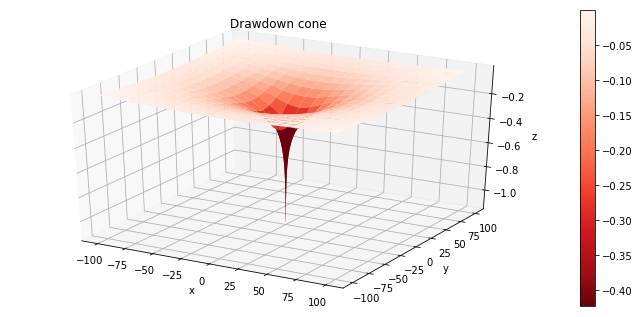

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Defining variables
h0_value=100
t=10*3600
step=0.1
radius=100.05
 

# ------------------------
# Drawdown function
def s(t,r,Q=1E-5,T=1E-5,S=1E-4):
    u=r**2*S/(4*T*t)
    W=-0.577215-np.log(u)+u-(u**2/(2*np.math.factorial(2)))
    +(u**3/(3*np.math.factorial(3)))-(u**4/(4*np.math.factorial(4)))
    s=(Q/(4*np.pi*T))*W 
    return s 
# ------------------------

# Generating the 2D meshgrid
r=np.array(np.arange(-radius,radius+step,step)) #r is the radius vector
(X, Y) = np.meshgrid(r, r)
distance = np.sqrt(X**2+Y**2)

# Calling the drawdown function
h = s(t, distance)

# Plotting in 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,12))

ax2 = fig.add_subplot(212, projection='3d')
sf = ax2.plot_surface(X, Y, -h, cmap='Reds_r', rstride=100, cstride=100)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.set_title("Drawdown cone")
fig.colorbar(sf)


In [6]:
# Here your code (theano version).

t_th = tt.scalar('time')
r_th = tt.matrix('radio')

# ...

In [12]:
IFrame('theano_graphs/drawdown.html', width=700, height=500)

In [ ]:
h_th = function(t, distance)

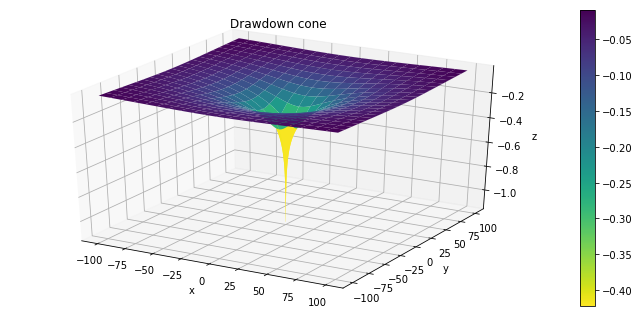

In [14]:
fig = plt.figure(figsize=(12,12))

ax2 = fig.add_subplot(212, projection='3d')
sf = ax2.plot_surface(X, Y, -h_th, cmap='viridis_r', rstride=100, cstride=100)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.set_title("Drawdown cone")
fig.colorbar(sf)

## Performance Comparison

Now that you have a numpy function and a theano function you can compare the performance for different resolutions (controlled by the step size) of one code and the other.

In [5]:
# Example of profiling
theano_gpu = []

for step in np.logspace(-1, 1, num=10):
    # Generating the 2D meshgrid
    r=np.array(np.arange(-radius,radius+step,step)) #r is the radius vector
    (X, Y) = np.meshgrid(r, r)
    distance = np.sqrt(X**2+Y**2)

    time = %timeit -r 2 -o function(t, distance)
    theano_gpu.append(time.best)

# You can save the results in a file using
np.save('gpu_results', theano_gpu)


11.1 ms ± 15.9 µs per loop (mean ± std. dev. of 2 runs, 100 loops each)
4.05 ms ± 33.9 µs per loop (mean ± std. dev. of 2 runs, 100 loops each)
1.54 ms ± 5.09 µs per loop (mean ± std. dev. of 2 runs, 1000 loops each)
729 µs ± 1.93 µs per loop (mean ± std. dev. of 2 runs, 1000 loops each)
483 µs ± 1.62 µs per loop (mean ± std. dev. of 2 runs, 1000 loops each)
403 µs ± 3.4 µs per loop (mean ± std. dev. of 2 runs, 1000 loops each)
91.8 µs ± 42.1 ns per loop (mean ± std. dev. of 2 runs, 10000 loops each)
365 µs ± 4.87 µs per loop (mean ± std. dev. of 2 runs, 1000 loops each)
364 µs ± 446 ns per loop (mean ± std. dev. of 2 runs, 1000 loops each)
359 µs ± 4.86 µs per loop (mean ± std. dev. of 2 runs, 1000 loops each)


In [ ]:
# Here you code

Next is to compare it with multi threading code. To do so you need to do something before you run the notebook. Theano documentation is your friend

In [ ]:
# Plotting the results
# Here your code

The final step would be to add also the gpu performance. For using the gpu you need a nvidia card (actually I think in the last update of Theano they made the compatibility with the rest of cards but I did not try). In any case, setting up the system for using GPUs it is a bit tricky so you do not need to try (spoilert alert: it is the fastest)).

## Automatic differentiation

However, although theano code optimization is useful, the real deal here is the automatic differentiation. There are extensive literature (for a clear explanation see \cite{baydin2015automatic}) explaining all the capabilities and intuitions of the method since it is the core algorithm to train neural networks. Here, we will highlight the main difference with numerical approaches and how can be exploited to improve the modelling process.

Many of the most advanced algorithms in computer science rely on an inverse framework i.e. the result of a forward computation f(\textbf{x}) influence the value of one or many of the \textbf{x} latent variables, being the most emblematic example of this is an optimization of a cost function. All these problems can be described somehow as an exploration of a multidimensional manifold $f: \mathbb{R}^N \rightarrow \mathbb{R}$ and hence the gradient of the function $\nabla f = \left(\frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, \frac{\partial f}{\partial x_n}\right)$ becomes key for an efficient analysis. In case that the output is also multidimensional---i.e. $f: \mathbb{R}^N \rightarrow \mathbb{R}^M$ the entire manifold gradient can be expressed by the Jacobian matrix

\begin{equation}
Jf =
\begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & ... & \frac{\partial f_1}{\partial x_n}\\
\vdots							& \ddots & \vdots \\
\frac{\partial f_n}{\partial x_1} & ... & \frac{\partial f_m}{\partial x_n}
\end{bmatrix}
\end{equation}
of dimension $N \cdot M$, where $N$ is the number of variables and $M$ the number of functions that depend on those variables. Once, we have posed the problem now the question is how we compute the Jacobian matrix in a consistent and effective manner.

The most straightforward methodology consist in approximate the derivate by numerical differentiation applying finite differences approximations
\begin{equation}
\frac{\partial f_i}{\partial x_i} = \lim_{\it{h}\to 0} \frac{f(x_i+h)-f(x_i)}{h}
\end{equation}

where h is some discrete increment. The main advantage of numerical differentiation is that only computes $f$---evaluated for different values of \textbf{x}---what makes it very easy to implement in any available code. By contrast, the drawback is that for every element of the Jacobian we are introducing an approximation error that eventually can lead to mathematical instabilities but above all, the main limitation is the need of $M \cdot N$ evaluations of the function $f$ what in high dimensional problems quickly becomes prohibitive computationally expensive.

The alternative is to create the symbolic differentiation of $f$, this is decomposing $f$ in its primal operators and applying the chain rule to the correspondent transformation following the rules of differentiation to obtain $f'$. However, symbolic differentiation is not enough since the application of the chain rule leads to exponentially large expressions of $f'$ in what is known as expression swell \citep{cohen2003computer}. Luckily these large symbolic expressions are highly redundant on their terms allowing to exploit this redundancy by storing the repeated intermediate steps in memory and simply invoke them when necessary instead of computing the whole graph every time. This division of the program in sub-routines to store the intermediate results which are invoked several times is called dynamic programming \citep{bellman2013dynamic}. The simplified symbolic differentiation graph is ultimately what is called automatic differentiation. But that is not all, in the multivariate/multi-objective case the benefits of using AD increases linearly as the difference between the number of parameters $N$ and the number of objective functions $M$ get larger. Applying the same principle of redundancy explained above---this time between intermediate steps shared across multiple variables or multiple objective function---it is possible to reduce the number of evaluations necessary to compute the Jacobian either to $N$ in forward propagation or to $M$  in back propagation plus a small overhead on the evaluations (for a more detail description of the two modes of AD see for instance \cite{cohen2003computer}).

In [17]:
# Declare the input variables
x = tt.dscalar('x') # In this case d is from double and scalar that is only
y = tt.dscalar('y') # a number
z = 2*(x + y**3)    # We define z as a deterministic operation of the input
z.name = 'z'        # We name the parameter. 
g = theano.grad(z, [x, y])
# We compile the function. Depending on theano configuration this would be
# in Python, C or Cuda
f_grad = theano.function([x, y], g)

In [21]:
d3v.d3viz(f_grad, 'theano_graphs/gradient.html')
IFrame('theano_graphs/gradient.html', width=700, height=500)

### Exercise: Compute the gradient

Try to compute the gradient of a point of the drawdown next to the well respect the constant parameters of the function (Q, T, S).

In [8]:
IFrame('theano_graphs/gradient_drawdown.html', width=700, height=500)

What means to have the gradient of a parameter respect the others?